# X-RAYS (PNEUMONIA) MODEL

In [1]:
# Connect GPU runtime in Colaboratory.
# GPU allocation and RAM that is available.
# Use GPU runtimes e.g.: TensorFlow or Pytorch.

!nvidia-smi

Mon Jun 27 06:14:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Dataset:   Chest X-Ray Images
# Other URL:  kaggle.com/paultimothymooney/chest-xray-pneumonia
# Link:      https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip

!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip

--2022-06-27 06:19:58--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2022-06-27 06:19:58--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc29cf52a6c8e6e4ad8a592fee56.dl.dropboxusercontent.com/cd/0/inline/Bn__VpuwFshGyBPfu0_jHcbcAIEBHSkhDvW0xUbJFiQfvaEFs6bo0DB0in7j6nbb-Bx7OSD8dz74jrufKd69o-KR8_itThfOCFykTPpXYpBCXwNX5bv-AjwcOTSGr4ynFgZ_XDcBFULLbFj74P4B6sJhmirzWpbnFm8vrm51jB00YQ/file# [following]
--2022-06-27 06:19:58--  https://uc29cf52a6c8e6e4ad8a592fee56.dl.dropboxusercontent.com/cd/0/inline/Bn__VpuwFshGyBPfu0_jHcbcAIEBHSkhDvW0xUbJFiQfvaEFs6bo0DB0in7j6nbb-Bx7

In [3]:
!unzip -q "archive.zip"

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [5]:
# create Pathlib generator object.
  # Pathlib's glob method returns a generator object.

train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")

In [6]:
# collect all the Paths inside the "Normal" and the "Pneumonia" folders in the paths above.

train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# output is a Generator object.

print(train_image_paths)

<generator object Path.glob at 0x7f0169936d50>


In [8]:
# convert Generator object to a List of elements

train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# output is PosixPath object(s)

print(train_image_paths[:3])

[PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0774-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0853-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0472-0001.jpeg')]


In [9]:
# convert Posixpaths to strings

train_image_paths = list(map(lambda x: str(x), train_image_paths))
val_image_paths = list(map(lambda x: str(x), val_image_paths))

print(train_image_paths[:3])

['chest_xray/train/NORMAL/NORMAL2-IM-0774-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0853-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0472-0001.jpeg']


In [10]:
# get the length for the Training and Validation datasets

train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [12]:
# every image has a label in its path.
  # slice the labels

LABELS = {'NORMAL' : 0, 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
  return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x: get_label(x), train_image_paths))
val_labels = list(map(lambda x: get_label(x), val_image_paths))

print(train_labels[:3])

[0, 0, 0]


# Loading and Transforming Image Data

### Load images as pixel data with libraries as 'Open CV', 'SK Image', and 'Python Image Library (PIL)'.

### The latest release of Tensorflow can load images more efficient.

<br />
## TENSORFLOW:

1. tf.io.read_file
- https://tensorflow.org/api_docs/python/tf/io/read_file

* Reads an image file and returns a decoded version of that image.

<br />
### Example (TF.IO.READ_FILE):

* Takes a string as the argument
* Returns an encoded string of that file.

<br />
**tf.io.read_file(
    filename, name=None
)**

<br />
2. tf.io.decode_jpeg
- https://tensorflow.org/api_docs/python/tf/io/decode_jpeg

* Takes arguments "content" which is the encoded string returned from tf.io.read_file.

* Channels: a normal image has 3 channels -> Red, Green, Blue -> (3) channels.

* Returns a Tensor of UINT8

<br />
### Example (TF.IO.DECODE_JPEG):

<br />
**tf.io.decode_jpeg(
    contents,
    channels=0,
    ratio=1,
    fancy_upscaling=True,
    try_recover_truncated=False,
    acceptable_fraction=1,
    dct_method='',
    name=None
)**

<br />
3. tf.image.resize
- https://www.tensorflow.org/api_docs/python/tf/image/resize

* Resizes the tensor

* Takes 3 arguments "image" which is the Tensor of the tf.io.decode_jpeg function, and "size" as argument, and "method" which is the compress/enlarge technique for the interpolation of the pixels

* images (Tensor output from the tf.io.decode_jpeg
* size = size to which it has to resize to.
* method - interpolation technique enlarged/compressed pixels.

<br />
### Example (TF.IMAGE.RESIZE):

<br />
**tf.image.resize(
    images,
    size,
    method=ResizeMethod.BILINEAR,
    preserve_aspect_ratio=False,
    antialias=False,
    name=None
)**

<br />
3. tf.image.random_flip_left_right
- https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right

<br />
* Data augmentation function that replaces image with manipulated version, to generalize better over images (as it looks in 7 different directions).

* Rotates image to left and right horizontally.

<br />
### Example (TF.IMAGE.RANDOM_FLIP_LEFT_RIGHT):

<br />
**tf.image.random_flip_left_right(
    image, seed=None
)**

In [13]:
# we have training and validation image paths and their respective labels

# higher batch size will require more RAM, lower batch size training will be slower
BATCH_SIZE = 32

# function for transformation
  ### ResNet 50 has input size [224, 224]

def load_and_transform(image, label, train=True):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [224, 224], method="nearest")
  if train:
    image = tf.image.random_flip_left_right(image)
  return image, label

In [14]:
# function used to create a Tensorflow Data Object

def get_dataset(paths, labels, train=True):
  image_paths = tf.convert_to_tensor(paths)
  labels = tf.convert_to_tensor(labels)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  label_dataset = tf.data.Dataset.from_tensor_slices(labels)

  dataset = tf.data.Dataset.zip((image_dataset, label_dataset)).shuffle(1000)

  dataset = dataset.map(lambda image, label : load_and_transform(image, label, train))
  dataset = dataset.repeat()
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE)

  return dataset

In [15]:
# create Train Dataset object and verify it

%time train_dataset = get_dataset(train_image_paths, train_labels)

image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 822 ms, sys: 547 ms, total: 1.37 s
Wall time: 4.81 s
(32, 224, 224, 3)
(32,)


PNEUMONIA


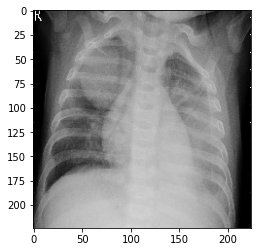

In [16]:
# view sample Train image

print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [17]:
# create Train Dataset object and verify it

%time val_dataset = get_dataset(val_image_paths, val_labels, train=False)

image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 16.3 ms
(32, 224, 224, 3)
(32,)


# CNN (MODEL ARCHITECTURE)